In [1]:
from clutter_filter import GroundClutterFilter
import numpy as np
import glob, os
# import radarkit
import radarkitIQ as radarkit
import momentgen as mg

In [42]:
fname = '../data/20240524/RAXPOL-20240524-002125.654.rkc'
# fname = '../data/20240524/RAXPOL-20240524-002604.135.rkc'
# fname = '../data/20240524/RAXPOL-20240524-002543.944.rkc'
# fname = '../data/20250518/RAXPOL-20250518-225404.925.rkc'
# fname = '../data/20250605/D2/RAXPOL-20250605-223837.894.rkc'
# fname = '../data/20250518/RAXPOL-20250518-230109.539.rkc'
# fname = '../data/20250518/RAXPOL-20250518-230114.467.rkc'
# fname = '../data/20250605/D1/RAXPOL-20250605-215634.580.rkc'
# fname = '../data/20250605/D2/RAXPOL-20250605-223837.894.rkc'
# rkid = radarkit.open(fname)
# out = rkid.read()

count = 250 # Pulses per ray
grf = True

rkid = radarkit.rkcfile(fname)
print(rkid.pulses)

Filename: ../data/20240524/RAXPOL-20240524-002125.654.rkc
preface = RadarKit/IQ   buildNo = 7
Pulse data size: 1364114816
gateCount = 12458   capacity = 36000   downSampledGateCount = 1246
data offset = 4792
Reading pulses ...
Number of pulses: 67772
[(3140555, 3167813, 785138750, 3311, 36000, 12458, 1246, 10, 35, 1716510085, 654387, 87685.64987578, [ 63, 234,   0,   0], [ 0, 41,  0,  0], 2, 0, 0, 3., 0.22522284, 269.9789  , 0., -5.636072, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [[[ 3.64420874e+03, -3.92375415e+03], [-3.32039124e+02,  9.48683090e+01], [ 1.89743757e+00,  1.33448105e+02], ..., [-8.22189331e+00,  8.85436058e+00], [-3.79467773e+00,  5.05962992e+00], [ 1.26488447e+00, -4.42721939e+00]], [[-1.44161904e+04, -9.10356445e+03], [-4.62325134e+02, -6.00200317e+02], [ 1.2

In [43]:
# ciq = out['ciq']

# pulses_new = []
# print(np.array(pulses[0]['iq'][0]))
# for pulse in pulses:
	# pulses_new.append(pulse['iq'])
# pulses = np.array(pulses_new)

pulses = rkid.pulses['iq']
# (pulse, iq, gate, hv)
pulses = pulses.transpose((1,2,3,0))
# (iq, gate, hv, pulse)
pulses = pulses[0,:,:,:] + 1.j*pulses[1,:,:,:]
# (gate, hv, pulse)
pulses = pulses.transpose((0,2,1)).astype(np.complex128)
# (gate, pulse, hv)

# ciq = pulses

# lamb = rkid.desc.wavelength
# prt = radarkit.read_RKFloat_array(rkid.configs.contents.prt,1)
lamb = rkid.header['desc']['wavelength']
prt = rkid.header['config']['prt']
c = 299,792,458
sample_freq = int(rkid.header['waveform']['fs'])
sample_time = 1/sample_freq
va = lamb/(4*prt)
# C = np.abs(radarkit.read_RKComplex_array(rkid.configs.contents.systemZCal, 1)[0])
# l = np.abs(radarkit.read_RKComplex_array(rkid.configs.contents.systemZCal, 2)[1])

totaln = pulses.shape[1]
rayCount = int(np.floor(totaln/count)) # Rays per sweep
gateCount = pulses.shape[0]
n = rayCount * count

az = rkid.pulses['azimuthDegrees']
el = rkid.pulses['elevationDegrees']

# # he's expecting ciq to be in (pulse, h/v, range)
# X_h = np.reshape(ciq[:n, 0, :], (rayCount, count, -1))
# # transpose (ray, pulse, range(?)) to (range, ray, pulse)
# X_h = np.transpose(X_h, (2, 0, 1))

# X_v = np.reshape(ciq[:n, 1, :], (rayCount, count, -1))
# X_v = np.transpose(X_v, (2, 0, 1))

X_h = pulses[:,:n,0]
# (gate, pulse)
X_h = np.reshape(X_h, (gateCount, rayCount, count))
# (gate, ray, pulse)

X_v = pulses[:,:n,1]
X_v = np.reshape(X_v, (gateCount, rayCount, count))

az = np.reshape(az[:n], (rayCount, count))
az = az[:,0]
el = np.reshape(el[:n], (rayCount, count))
el = np.nanmean(el, axis=1)


In [44]:
if grf:
	# set some imporatnt radar parameter
	wavelength_scalar = lamb
	# prt_scalar = prt[0]
	num_samples_actual = X_h.shape[2]

	#filter the I/Q time series for the horizontal and vertical polarizations
	filter_inst = GroundClutterFilter(
		wavelength=lamb,
		scan_rate=1/(count * prt),
		prt=prt,
		num_samples=count
	)

	print("\n--- Filtering X_h (Horizontal Polarization) ---")
	filtered_i_h, filtered_q_h, poly_order_map_h, clutter_i_trend_map_h, clutter_q_trend_map_h, interpolated_spectrum_map_h = \
		filter_inst.filter_iq_data(X_h.real, X_h.imag, cnr_db_map=None, apply_interpolation=True)

	filtered_X_h_optimized = filtered_i_h + 1j * filtered_q_h

	del filtered_i_h, filtered_q_h, poly_order_map_h, clutter_i_trend_map_h, clutter_q_trend_map_h, interpolated_spectrum_map_h

	print("\n--- Filtering X_v (Vertical Polarization) ---")
	filtered_i_v, filtered_q_v, poly_order_map_v, clutter_i_trend_map_v, clutter_q_trend_map_v, interpolated_spectrum_map_v = \
		filter_inst.filter_iq_data(X_v.real, X_v.imag, cnr_db_map=None, apply_interpolation=True)

	filtered_X_v_optimized = filtered_i_v + 1j * filtered_q_v

	del filtered_i_v, filtered_q_v, poly_order_map_v, clutter_i_trend_map_v, clutter_q_trend_map_v, interpolated_spectrum_map_v

	print("\nOptimization complete. Filtered data is in filtered_X_h_optimized and filtered_X_v_optimized.")

Filter initialized with:
  Wavelength: 0.0308 m
  Scan Rate: 16.0 deg/s
  PRT: 0.0002500000118743628 s
  Number of Samples per gate: 250
  Nyquist Velocity: 30.80 m/s

--- Filtering X_h (Horizontal Polarization) ---
Processing 337666 cells (1246 range gates, 271 azimuthal positions)...
Estimating CNR for all cells...
  _estimate_clutter_power_from_polyfit: i_series.shape = (337666, 250)
  _estimate_clutter_power_from_polyfit: q_series.shape = (337666, 250)
  _estimate_clutter_power_from_polyfit: t.shape = (250,)
  _estimate_clutter_power_from_polyfit: i_series_T.shape = (250, 337666)
  _estimate_clutter_power_from_polyfit: coeffs_i.shape = (3, 337666)
  _estimate_clutter_power_from_polyfit: clutter_i.shape = (337666, 250)
  _estimate_clutter_power_from_polyfit: clutter_q.shape = (337666, 250)
  _estimate_clutter_power_from_polyfit: clutter_power_i.shape = (337666,)
  _estimate_clutter_power_from_polyfit: total_clutter_power.shape = (337666,)
Determining polynomial orders...
Performing 

Batch Gaussian Interpolation:   0%|          | 0/87597 [00:00<?, ?it/s]


--- Filtering X_v (Vertical Polarization) ---
Processing 337666 cells (1246 range gates, 271 azimuthal positions)...
Estimating CNR for all cells...
  _estimate_clutter_power_from_polyfit: i_series.shape = (337666, 250)
  _estimate_clutter_power_from_polyfit: q_series.shape = (337666, 250)
  _estimate_clutter_power_from_polyfit: t.shape = (250,)
  _estimate_clutter_power_from_polyfit: i_series_T.shape = (250, 337666)
  _estimate_clutter_power_from_polyfit: coeffs_i.shape = (3, 337666)
  _estimate_clutter_power_from_polyfit: clutter_i.shape = (337666, 250)
  _estimate_clutter_power_from_polyfit: clutter_q.shape = (337666, 250)
  _estimate_clutter_power_from_polyfit: clutter_power_i.shape = (337666,)
  _estimate_clutter_power_from_polyfit: total_clutter_power.shape = (337666,)
Determining polynomial orders...
Performing regression filtering on I series...
  _perform_regression_filter: selected_series.shape = (296141, 250)
  _perform_regression_filter: clutter_trend.shape = (296141, 250)

Batch Gaussian Interpolation:   0%|          | 0/30288 [00:00<?, ?it/s]


Optimization complete. Filtered data is in filtered_X_h_optimized and filtered_X_v_optimized.


In [45]:
noise = rkid.header['config']['noise']
N_h, N_v = noise 
if rkid.header['buildNo'] >= 4:
	if rkid.header['dataType'] == 'raw':
		dr = rkid.header['config']['pulseGateSize']
		# dt = dr * 2 / (c/1e6)
	elif rkid.header['dataType'] == 'compressed':
		dr = rkid.header['desc']['pulseToRayRatio'] * rkid.header['config']['pulseGateSize']
		# dt = dr * 2 / (c/1e6)
	else:
		print("Inconsistency detected. This should not happen.")
		dr = 30.
		# dt = 1./50
else:
	dr = 30.
	# dt = 1./50

# rr = (dr/2) + (np.arange(0,ng,gstep) * dr)

R = np.arange(0, gateCount)*dr
C = rkid.header['config']['ZCal']
Cd = rkid.header['config']['DCal']
Cp = rkid.header['config']['PCal']

if grf:
	moments = mg.get_moments(filtered_X_h_optimized, filtered_X_v_optimized, N_h, N_v, R, va, C, Cd, Cp)
else:
	moments = mg.get_moments(X_h, X_v, N_h, N_v, R, va, C, Cd, Cp)

In [46]:
from raxpolCf import raxpolCf

if not grf:
	fname_out = '../data/out/20240524/out.nc'
else: 
	fname_out = '../data/out/20240524/out-f.nc'

rcf = raxpolCf()
rcf.setVolume()
rcf.setSweep()
rcf.setTime((rkid.pulses['time_tv_sec'][:n:count]).astype(np.float64))
rcf.setRange(R.astype(np.float32))
rcf.setPosition(np.nanmean(rkid.header['desc']['latitude']), np.nanmean(rkid.header['desc']['longitude']))
rcf.setScanningStrategy('ppi')
rcf.setTargetAngle(np.nanmean(rkid.pulses['elevationDegrees']))
rcf.setAzimuth(az)
rcf.setElevation(el)
rcf.setPulseWidthSeconds((rkid.pulses['pulseWidthSampleCount'][:n:count]*sample_time).astype(np.float32))
rcf.setPrtSeconds(np.tile(prt, (rayCount,1)))
rcf.setWavelengthMeters(np.tile(lamb, (rayCount,1)))

# print(np.nanmax(moments['DBZ']))
rcf.setDBZ(moments['DBZ'])
rcf.setVEL(moments['VEL'])
rcf.setWIDTH(moments['WIDTH'])
rcf.setZDR(moments['ZDR'])
rcf.setRHOHV(moments['RHOHV'])
rcf.setPHIDP(moments['PHIDP'], units='degrees')
rcf.setSNRH(moments['SNRH'])
rcf.setSNRV(moments['SNRV'])

rcf.saveToFile(fname_out)

In [47]:
import pyart
import matplotlib.pyplot as plt

In [68]:
si = 0

xlim = (-4, 0)
ylim = (2, 6)

zdr_offset = -5
# ds = -50
interval_splits = 4

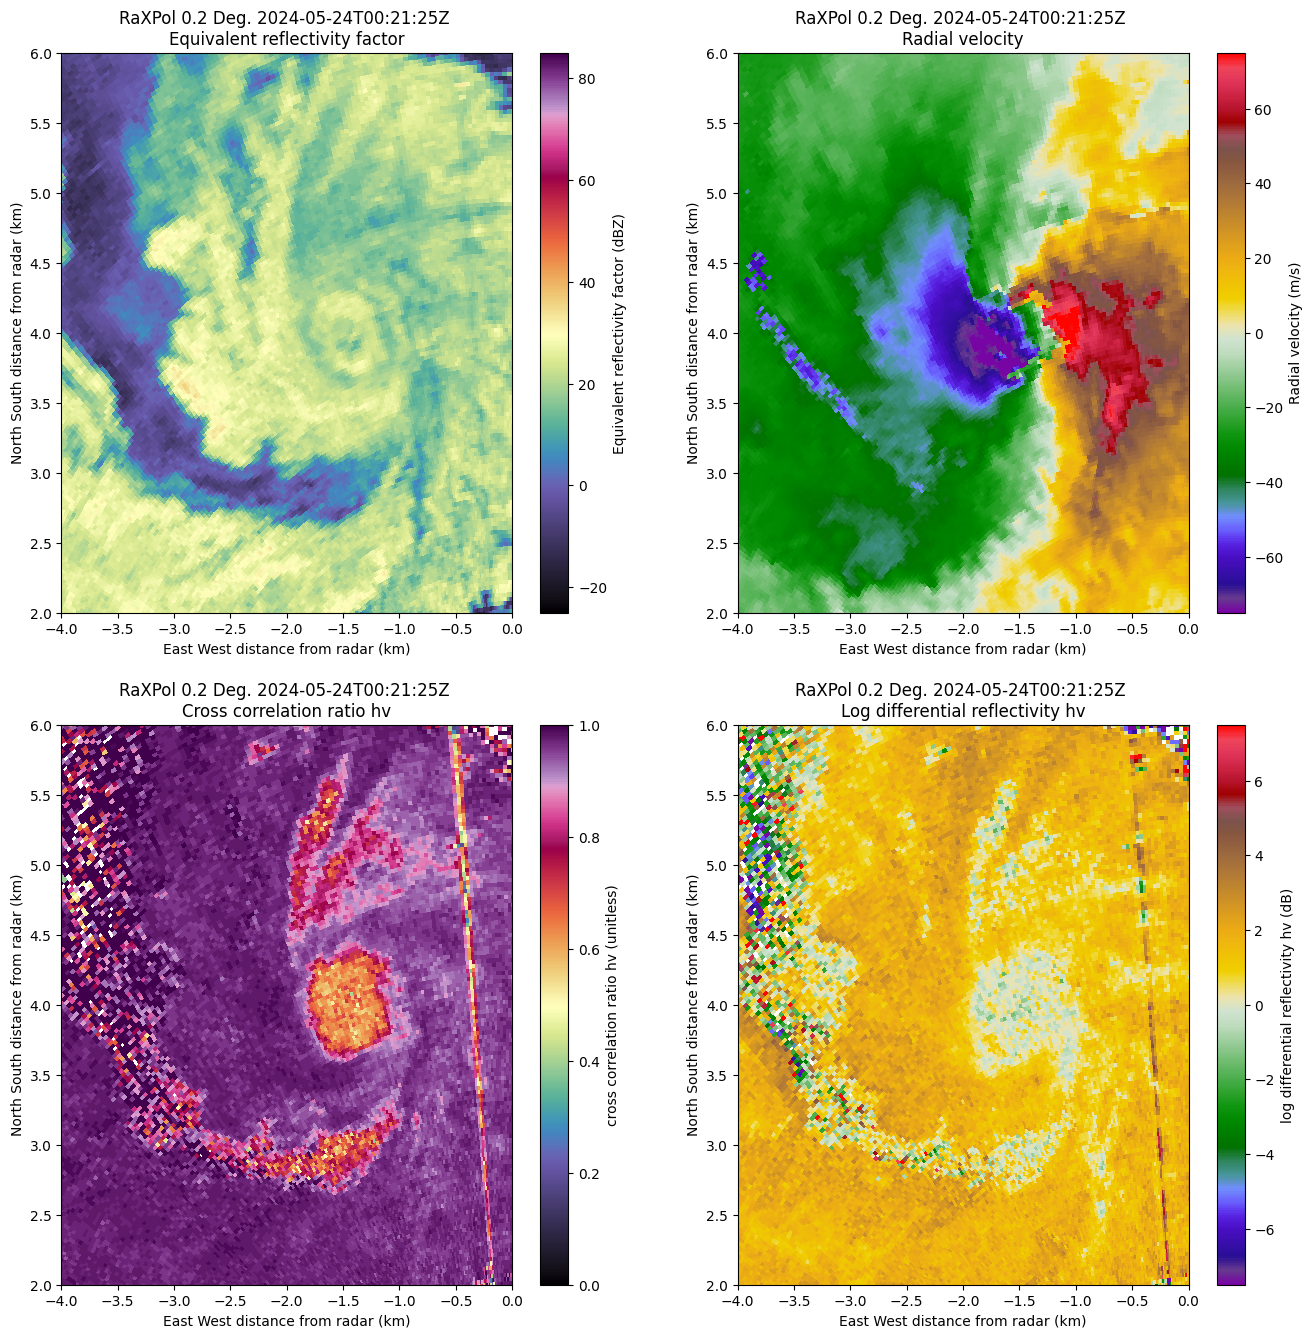

In [69]:
fname_out = '../data/out/20240524/out.nc'

robj = pyart.io.read(fname_out)
fig, axm = plt.subplots(2,2,figsize=(16,16))
disp = pyart.graph.RadarDisplay(robj)

axm = axm.flatten()

"""where = np.where(robj.fields['SNRH']['data'] < ds) # np.where(robj.fields['DBZ']['data'] < -50)
robj.fields['VEL']['data'][where] = np.nan
robj.fields['RHOHV']['data'][where] = np.nan
robj.fields['ZDR']['data'][where] = np.nan
robj.fields['WIDTH']['data'][where] = np.nan"""

robj.fields['ZDR']['data'] = robj.fields['ZDR']['data'] + zdr_offset

robj.add_field('VELD', pyart.correct.dealias_region_based(robj, vel_field='VEL', interval_splits=interval_splits))
# robj.add_field('VELD', pyart.correct.dealias_unwrap_phase(robj, vel_field='VEL', unwrap_unit='ray'))

sweep = robj.get_slice(si)

# zz = u.get_heights(robj.range['data'], robj.elevation['data'][sweep])
# xx, yy = u.get_xxyy(robj.azimuth['data'][sweep], robj.range['data'], robj.elevation['data'][sweep])



# heights = np.arange(0, 500, 10)
# con = ax.contour(xx/1e3, yy/1e3, zz, heights, linewidth=0.5, colors='k')
# ax.clabel(con)
# print(robj.elevation['data'][sweep])

# print(robj.fields.keys())
# dict_keys(['DBZ', 'DBZ1', 'ZDR', 'VEL', 'VELV', 'VELH', 'WIDTH', 'PHIDP', 'KDP', 'RHOHV', 'DBMHC', 'DBMVC', 'SNRHC', 'SNRVC', 'NCP', 'BMHGHT', 'DBZC', 'ZDRC'])

ax = axm[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['DBZ']['standard_name'] = 'Equivalent reflectivity factor'
disp.plot_ppi('DBZ', si, cmap='ChaseSpectral', ax=ax, vmin=-25, vmax=85)

ax = axm[1]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['VELD']['standard_name'] = 'Radial velocity'
robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('VELD', si, cmap='Carbone42', ax=ax, vmin=-75, vmax=75)

ax = axm[2]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('RHOHV', si, cmap='ChaseSpectral', ax=ax, vmin=0, vmax=1)

ax = axm[3]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('ZDR', si, cmap='Carbone42', ax=ax, vmin=-7.5, vmax=7.5)

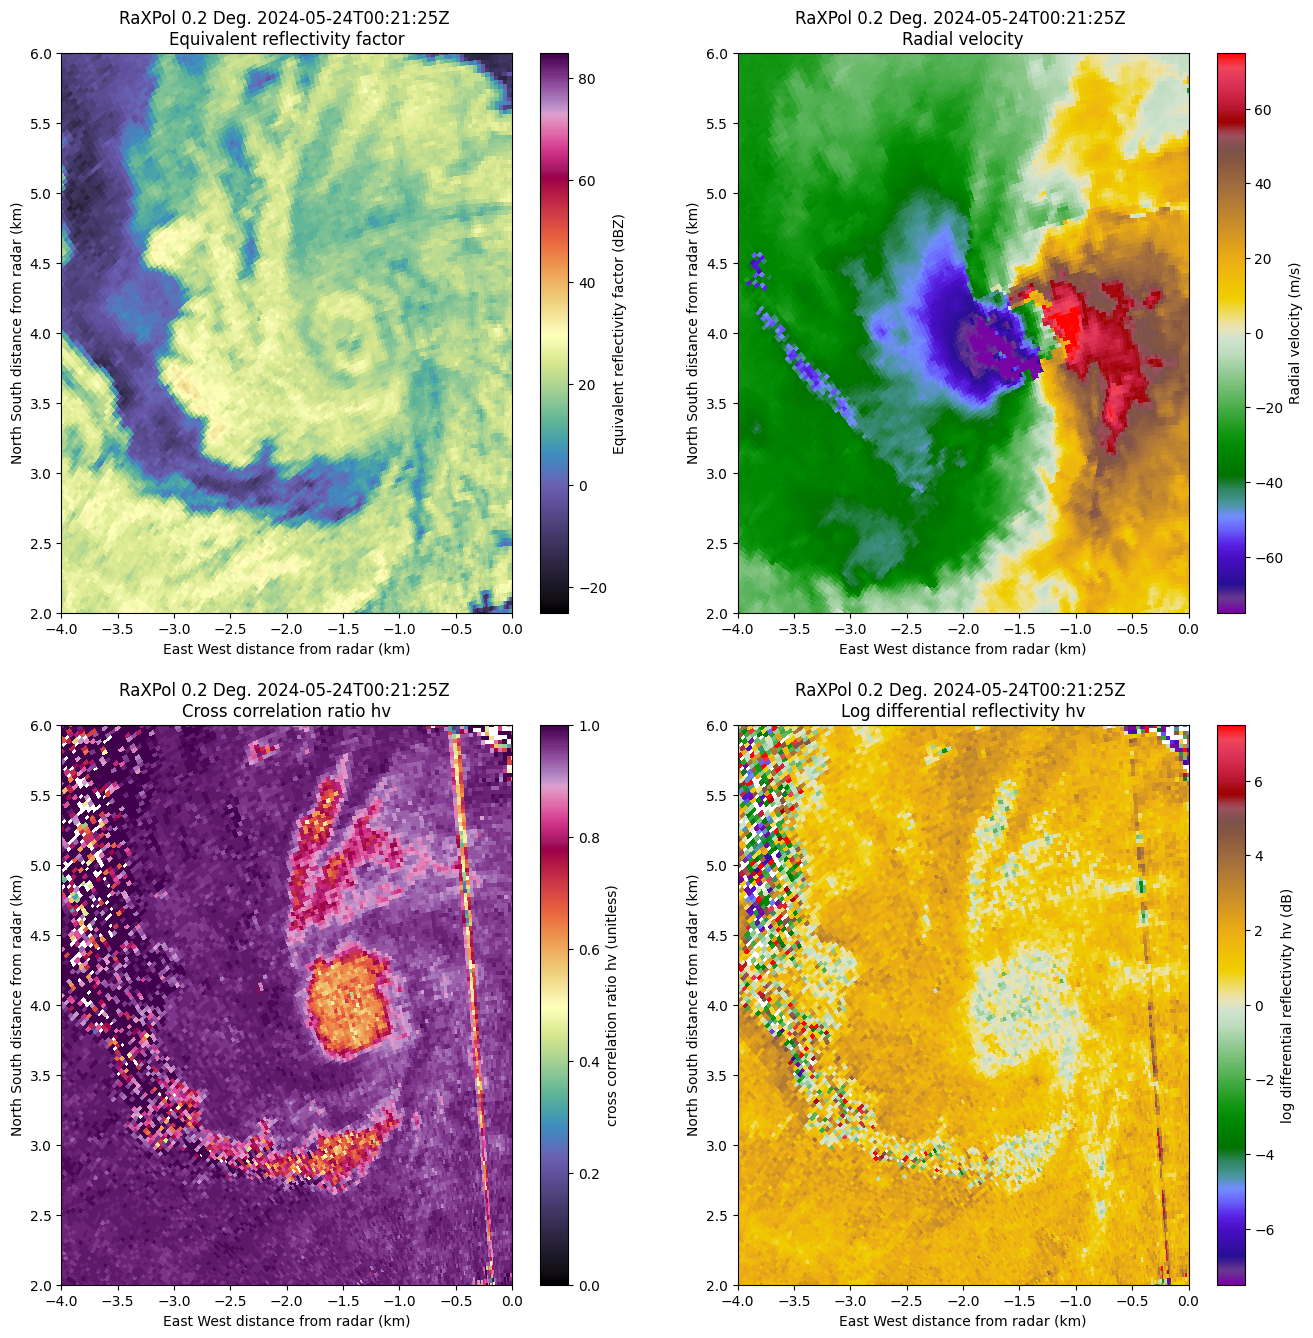

In [70]:
fname_out = '../data/out/20240524/out-f.nc'

robj = pyart.io.read(fname_out)
fig, axm = plt.subplots(2,2,figsize=(16,16))
disp = pyart.graph.RadarDisplay(robj)

axm = axm.flatten()

"""where = np.where(robj.fields['SNRH']['data'] < ds) # np.where(robj.fields['DBZ']['data'] < -50)
robj.fields['VEL']['data'][where] = np.nan
robj.fields['RHOHV']['data'][where] = np.nan
robj.fields['ZDR']['data'][where] = np.nan
robj.fields['WIDTH']['data'][where] = np.nan"""

robj.fields['ZDR']['data'] = robj.fields['ZDR']['data'] + zdr_offset

robj.add_field('VELD', pyart.correct.dealias_region_based(robj, vel_field='VEL', interval_splits=interval_splits))
# robj.add_field('VELD', pyart.correct.dealias_unwrap_phase(robj, vel_field='VEL', unwrap_unit='ray'))

sweep = robj.get_slice(si)

# zz = u.get_heights(robj.range['data'], robj.elevation['data'][sweep])
# xx, yy = u.get_xxyy(robj.azimuth['data'][sweep], robj.range['data'], robj.elevation['data'][sweep])



# heights = np.arange(0, 500, 10)
# con = ax.contour(xx/1e3, yy/1e3, zz, heights, linewidth=0.5, colors='k')
# ax.clabel(con)
# print(robj.elevation['data'][sweep])

# print(robj.fields.keys())
# dict_keys(['DBZ', 'DBZ1', 'ZDR', 'VEL', 'VELV', 'VELH', 'WIDTH', 'PHIDP', 'KDP', 'RHOHV', 'DBMHC', 'DBMVC', 'SNRHC', 'SNRVC', 'NCP', 'BMHGHT', 'DBZC', 'ZDRC'])

ax = axm[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['DBZ']['standard_name'] = 'Equivalent reflectivity factor'
disp.plot_ppi('DBZ', si, cmap='ChaseSpectral', ax=ax, vmin=-25, vmax=85)

ax = axm[1]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['VELD']['standard_name'] = 'Radial velocity'
robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('VELD', si, cmap='Carbone42', ax=ax, vmin=-75, vmax=75)

ax = axm[2]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('RHOHV', si, cmap='ChaseSpectral', ax=ax, vmin=0, vmax=1)

ax = axm[3]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('ZDR', si, cmap='Carbone42', ax=ax, vmin=-7.5, vmax=7.5)